REFERENCES:  https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/
,

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 ,

https://keras.io/guides/training_with_built_in_methods/ ,

https://towardsdatascience.com/how-to-choose-the-optimal-learning-rate-for-neural-networks-362111c5c783

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas  matplotlib scikit-learn scipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import time
import pandas as pd
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from itertools import islice
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import softmax
import gc
import itertools
from sklearn.metrics import mean_squared_error
import sklearn
from numpy import genfromtxt
from os import listdir
from os.path import isfile, join
import os
import copy
from scipy import interpolate
from scipy.spatial import distance
import time
import numpy as np

#np.set_printoptions(suppress=True)


def load_dataset(datasets,shape,labels):
    start = time.time()
    count = 1
    wavelength_list = []
    intensity_list = []
    label_list = []
    get_wavelength = True
    for dataset_name in datasets:
        with h5py.File(dataset_name, "r") as f:
            if get_wavelength: wavelengths = np.array(np.split(f['wavelength'][:], f['wavelength'][:].shape[0]//shape))
            intensities = np.array(np.split(f['intensity'][:], f['intensity'][:].shape[0]//shape))
            labels = np.array(np.split(f['label'][:], f['label'][:].shape[0]//labels))/100
            if get_wavelength: wavelength_list.append(wavelengths)
            intensity_list.append(intensities)
            label_list.append(labels)
            print(dataset_name, " Done")
        get_wavelength = False
    wavelengths = np.array(list(itertools.chain.from_iterable(wavelength_list)))
    intensities = np.array(list(itertools.chain.from_iterable(intensity_list)))
    labels = np.array(list(itertools.chain.from_iterable(label_list)))
    print(round(time.time()-start,2), "seconds")    
    return wavelengths, intensities, labels



In [5]:
datasets_to_load = ['/content/drive/MyDrive/SAMK/LIBS/dataset7.h5']
wavelengths_list, c, labels_list = load_dataset(datasets_to_load,4094,24)
current_elements = ['C', 'Mg', 'Al', 'Si', 'Ti', 'V', 'Fe', 'Co', 'Ni', 'Cu', 'Mn', 'Li', 'Zn', 'O', 'P', 'Pt', 'Au', 'Ag', 'Ir', 'W', 'Pd', 'Sn', 'Tc', 'Y']


/content/drive/MyDrive/SAMK/LIBS/dataset7.h5  Done
121.07 seconds


In [ ]:
#current_elements.index('O')

In [6]:
df_wavelengths=pd.DataFrame(wavelengths_list)
df_wavelengths.shape


(53660, 4094)

In [7]:
df_intensity=pd.DataFrame(c)
df_intensity.shape

(53660, 4094)

In [27]:
print(df_intensity[45])

0        3.916645e-20
1        1.251440e-18
2        3.748080e-18
3        0.000000e+00
4        2.402465e-01
             ...     
53655    0.000000e+00
53656    9.149658e-01
53657    9.149658e-01
53658    7.270576e+01
53659    3.342832e+00
Name: 45, Length: 53660, dtype: float64


3.916645e-20
,1.251440e-18
,3.748080e-18
, 0.000000e+00
, 2.402465e-01    
, 0.000000e+00
,9.149658e-01
, 9.149658e-01
,7.270576e+01
,3.342832e+00

In [8]:
df_labels_list=pd.DataFrame(labels_list)
df_labels_list.shape

(53660, 24)

## Plot intensities

In [ ]:
plt.plot(df_intensity)
#plt.ylim([0,100])

AttributeError: ignored

In [23]:
df_labels_list[13]!=0.0

0        False
1        False
2        False
3        False
4        False
         ...  
53655    False
53656    False
53657    False
53658    False
53659    False
Name: 13, Length: 53660, dtype: bool

In [ ]:
#row 13 is 'O' which is gas element so droping all the rows which has oxygen
#get rows with gas elements .i.e. rows which has value other than 0 in column 13
rows_gas = df_labels_list[(df_labels_list[[13]] != 0.0).all(axis=1)]
rows_gas

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
36,0.99,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
58,0.00,0.99,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
79,0.00,0.00,0.99,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
99,0.00,0.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53535,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.30,0.0
53536,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.00,0.3
53537,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.30,0.0
53538,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.00,0.3


In [ ]:
rows_of_gas=rows_gas.index
rows_of_gas

Int64Index([   13,    36,    58,    79,    99,   118,   136,   153,   169,
              184,
            ...
            53530, 53531, 53532, 53533, 53534, 53535, 53536, 53537, 53538,
            53539],
           dtype='int64', length=5567)

In [ ]:

df_intensity=df_intensity.drop(index=rows_of_gas)
df_intensity.shape

(48093, 4094)

In [ ]:
df_wavelengths=df_wavelengths.drop(index=rows_of_gas)
df_wavelengths.shape

(48093, 4094)

In [ ]:
df_labels_list=df_labels_list.drop(index=rows_of_gas)
df_labels_list.shape



(48093, 24)

In [ ]:
df_labels_list=df_labels_list.drop(13, axis=1)
df_labels_list.shape

(48093, 23)

## split dataset for train set and test set

In [ ]:
x=df_intensity
y=df_labels_list

In [ ]:
# Split x into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
#X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
# Print the shape of the resulting data sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (43283, 4094)
y_train shape: (43283, 23)
X_test shape: (4810, 4094)
y_test shape: (4810, 23)


In [ ]:
# Compile the model
def create_model(my_learning_rate):
    model = tf.keras.models.Sequential()
    model.add(Dense(3000, batch_input_shape=(None,4094), activation='relu',name="input"))
    model.add(Dense(2000, batch_input_shape=(None,4094), activation='relu',name="layer_1"))
    model.add(Dense(1000, batch_input_shape=(None,4094), activation='relu',name="layer_2"))
    model.add(Dense(750, batch_input_shape=(None,4094), activation='relu',name="layer_3"))
    model.add(Dense(500, batch_input_shape=(None,4094), activation='relu',name="layer_4"))
    model.add(Dense(250, batch_input_shape=(None,4094), activation='relu',name="layer_5"))
    model.add(Dense(100, batch_input_shape=(None,4094), activation='relu',name="layer_6"))
    model.add(Dense(46, batch_input_shape=(None,4094), activation='relu',name="layer_7"))
    model.add(Dense(23, activation=softmax,name="output"))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=my_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model 


In [ ]:
# Train the model
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=2,
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [ ]:
# model.fit(x=train_features, y=train_label, batch_size=batch_size,epochs=epochs, shuffle=True, validation_split=validation_split)

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.009
epochs = 100
batch_size = 32
validation_split = 0.2


In [ ]:
# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, X_train, y_train, 
                           epochs, batch_size, validation_split)

In [ ]:
#epochs= 100 lr=0.005
my_model.summary()

In [ ]:
#epochs= 200 lr=0.03
my_model.summary()

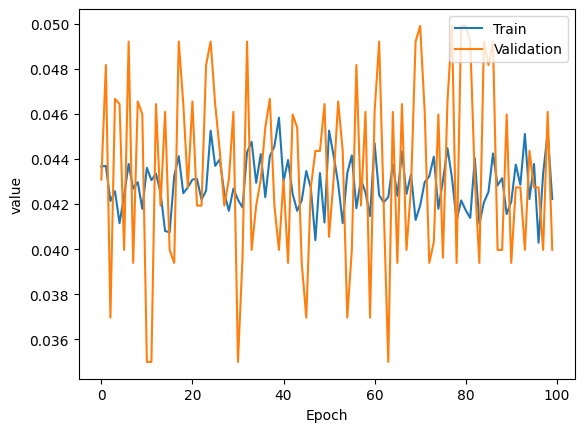

In [ ]:
#epoch=100 lr=0.009
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

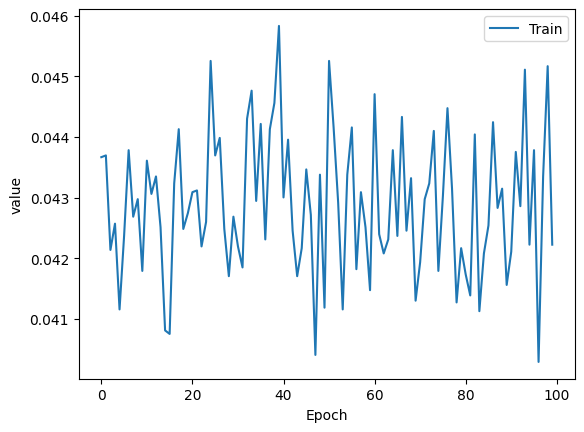

In [ ]:
#epoch=200 lr=0.01
plt.plot(hist['accuracy'], label='Train')
#plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [ ]:
#epoch=100 lr=0.009
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 2ms/step - loss: 3.1370 - accuracy: 0.0378


[3.1369805335998535, 0.037837836891412735]

In [ ]:
#epoch=200 lr=0.01
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 3ms/step - loss: 3.1375 - accuracy: 0.0424


[3.137483596801758, 0.042411644011735916]

In [ ]:
#epoch=100 lr=0.01
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 3ms/step - loss: 3.1366 - accuracy: 0.0432


[3.1366288661956787, 0.04324324429035187]

In [ ]:
#epoch=100 lr=0.005
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 2ms/step - loss: 3.1365 - accuracy: 0.0383


[3.1364829540252686, 0.03825363889336586]

In [ ]:
#epoch=400 lr=0.03
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 3ms/step - loss: 3.1404 - accuracy: 0.0476


[3.1403727531433105, 0.04760914668440819]

In [ ]:
#epoch=300 lr=0.03
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 2ms/step - loss: 3.1418 - accuracy: 0.0407


[3.141843557357788, 0.040748439729213715]

In [ ]:
#epoch=200 lr=0.03
# Evaluate against the test set. 
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
151/151 [==============================] - 0s 2ms/step - loss: 3.1413 - accuracy: 0.0380


[3.141313314437866, 0.0380457378923893]

In [ ]:
df_predictions = pd.DataFrame(predictions)
df_predictions

In [ ]:
predictions = model.predict(X_val)

271/271 [==============================] - 1s 2ms/step


In [ ]:
predictions

In [ ]:
df_predictions_original = pd.DataFrame(y_val)
df_predictions_original

In [ ]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


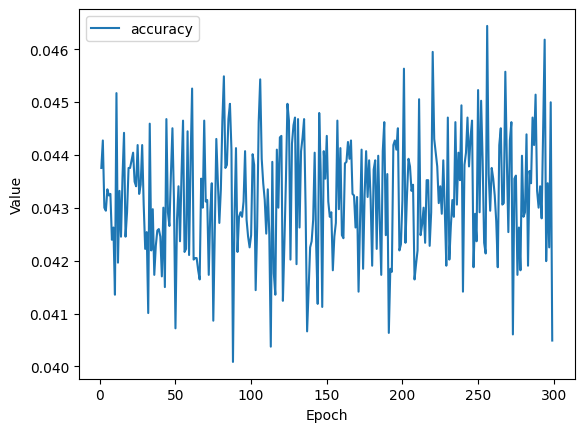

In [ ]:
#epochs = 300 lr=0.03
# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

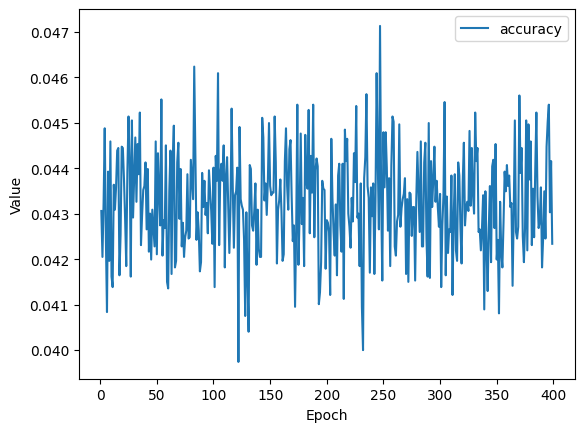

In [ ]:
#epochs=400 lr=0.03
# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
hist

,loss,accuracy,val_loss,val_accuracy
0,1.302241e+08,0.043002,3.140552,0.046090
1,3.140263e+00,0.043060,3.139686,0.045397
2,3.140132e+00,0.042049,3.141008,0.045166
3,3.139895e+00,0.043233,3.142128,0.045974
4,3.140189e+00,0.044880,3.140931,0.040314
...,...,...,...,...
395,3.140001e+00,0.045024,3.141809,0.039621
396,3.140138e+00,0.045399,3.143683,0.035001
397,3.140124e+00,0.043031,3.141659,0.039968
398,3.140396e+00,0.044158,3.140692,0.036964


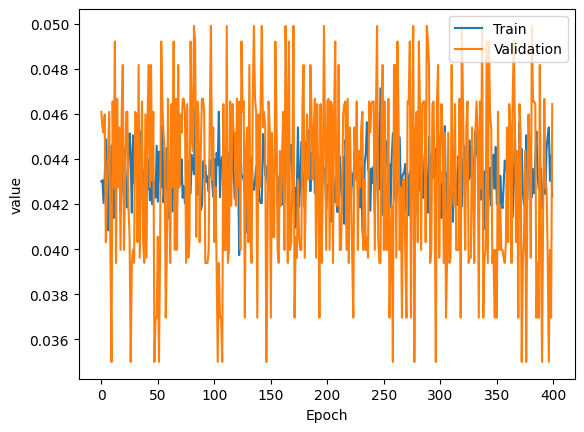

In [ ]:
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test,batch_size=batch_size)


NameError: name 'model' is not defined

In [ ]:
# Make predictions
predictions = model.predict(X_new)

In [ ]:
model = Sequential()
model.add(Dense(2000, batch_input_shape=(None,4094),activation='relu'))
model.add(Dense(1000, batch_input_shape=(None,4094),activation='relu'))
model.add(Dense(100, batch_input_shape=(None,4094),activation='relu'))
model.add(Dense(64, batch_input_shape=(None,4094),activation='relu'))
model.add(Dense(23, activation=softmax))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Make predictions
#predictions = model.predict(X_new)